<a href="https://colab.research.google.com/github/N4tth/taller2-RN/blob/main/vanillaRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import itertools
import pandas as pd
import kagglehub

from kagglehub import KaggleDatasetAdapter

In [ ]:
#preprocessing
dataset_path = kagglehub.dataset_download("new-york-city/nyc-dog-names")
print("Ruta del dataset descargado:", dataset_path)

for f in os.listdir(dataset_path):
    if f.endswith(".csv"):
        csv_path = os.path.join(dataset_path, f)
        break


df = pd.read_csv(csv_path)
print("Dataset cargado correctamente")

print("Shape:", df.shape)
print("Columnas:", df.columns.tolist())
print(df.head())



100%|██████████| 55.3k/55.3k [00:00<00:00, 38.4MB/s]

Extracting files...
Ruta del dataset descargado: /root/.cache/kagglehub/datasets/new-york-city/nyc-dog-names/versions/1
Dataset cargado correctamente
Shape: (16220, 2)
Columnas: ['Row_Labels', 'Count_AnimalName']
  Row_Labels  Count_AnimalName
0          1                 1
1          2                 2
2      40804                 1
3      90201                 1
4      90203                 1


In [ ]:
#Preprocessing
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_#]+', '', regex=True)
print("COlumnas limpias: ", df.columns.tolist())

col_name = None
col_count = None

for c in df.columns:
  if "row" in c.lower():
      col_name = c
  if "count" in c.lower():
    col_count = c
if not col_name or not col_count:
  raise ValueError("No se encontraron columnas de nombres o conteo")
print(f"Usando columnas → Nombres: {col_name}, Conteos: {col_count}")

names = df[col_name].dropna().astype(str).tolist()
counts = df[col_count].fillna(1).astype(int).tolist()

clean_names = []
for name, count in zip(names, counts):
  name = name.lower().strip()
  name = re.sub(r'[^a-zñáéíóú ]', '', name)
  if 2 <= len(name) <=12:
    repetitions = min(count, 10)
    clean_names.extend([name] * repetitions)
print(f"total nombres limpios: {len(clean_names)}")
print("Ejemplos: ", clean_names[:10])
#Corpus
text = "\n".join(clean_names)
print(f"LOngitud total del texto: {len(text)} carácteres")
#Tokenization
chars = sorted(list(set(text)))
char_to_int = {ch:i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

print(f"Num caracteres únicos: {vocab_size}")
print("Ejemplos vocabulario:", chars[:20])

def get_subset_text(text, size):
  if len(text) < size:
    size = len(text)
  return text[:size]



COlumnas limpias:  ['Row_Labels', 'Count_AnimalName']
Usando columnas → Nombres: Row_Labels, Conteos: Count_AnimalName
total nombres limpios: 43391
Ejemplos:  ['march', 'march', 'april', 'april', 'april', 'april', 'april', 'april', 'april', 'april']
LOngitud total del texto: 290009 carácteres
Num caracteres únicos: 33
Ejemplos vocabulario: ['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's']


seq_length. Que es el número de neuronas recurrentes. 64, 128, 256
words. Tamaño del conjunto de datos. 5000, 20000, 50000
max_iter. Número de iteraciones/época. 30, 50, 80


In [ ]:
seq_lengths = [64, 128, 256]
dataset_sizes = [5000, 20000, 50000]
max_iters = [30, 50, 80]
clip_options = [True, False]

experiments = list(itertools.product(seq_lengths, dataset_sizes, max_iters, clip_options))
results = []

In [ ]:
#Vanilla neural network from https://lucyliu-ucsb.github.io/posts/Backpropagation-of-a-vanilla-RNN with modifications
class VanillaRNN:
    def __init__(self, n_x, n_h, seq_length, learning_rate):
        self.n_x = n_x
        self.n_h = n_h
        self.seq_length = seq_length
        self.learning_rate = learning_rate

        self.Wxh = np.random.randn(n_h, n_x) * 0.01
        self.Whh = np.random.randn(n_h, n_h) * 0.01
        self.Why = np.random.randn(n_x, n_h) * 0.01
        self.bh = np.zeros((n_h, 1))
        self.by = np.zeros((n_x, 1))


        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh)
        self.mWhy = np.zeros_like(self.Why)
        self.mbh = np.zeros_like(self.bh)
        self.mby = np.zeros_like(self.by)

    def forward_pass(self, inputs, targets, hprev):
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(hprev)
        loss = 0

        for t in range(len(inputs)):
            x[t] = np.zeros((self.n_x, 1))
            x[t][inputs[t]] = 1
            h[t] = np.tanh(self.Wxh @ x[t] + self.Whh @ h[t-1] + self.bh)
            y[t] = self.Why @ h[t] + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
            loss -= np.log(p[t][targets[t], 0])

        return loss, x, h, p

    def backpropagation(self, x, h, p, targets, clip=True):
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h[0])

        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] -= 1
            dWhy += dy @ h[t].T
            dby += dy
            dh = self.Why.T @ dy + dhnext
            dhraw = (1 - h[t] * h[t]) * dh
            dbh += dhraw
            dWxh += dhraw @ x[t].T
            dWhh += dhraw @ h[t-1].T
            dhnext = self.Whh.T @ dhraw

        # Clipping enabling. Since there's no interface, the parameter "clip" functions as a switch
        if clip:
            for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
                np.clip(dparam, -5, 5, out=dparam)

        return dWxh, dWhh, dWhy, dbh, dby

    def update_para(self, dWxh, dWhh, dWhy, dbh, dby):
        for param, dparam, mem in zip(
            ['Wxh', 'Whh', 'Why', 'bh', 'by'],
            [dWxh, dWhh, dWhy, dbh, dby],
            ['mWxh', 'mWhh', 'mWhy', 'mbh', 'mby']
        ):
            setattr(self, mem, getattr(self, mem) + dparam * dparam)
            setattr(self, param, getattr(self, param) -
                    self.learning_rate * dparam / np.sqrt(getattr(self, mem) + 1e-8))

    def train(self, text, char_to_int, int_to_char, max_iter=10000, clip=True):
        iter_num, pos = 0, 0
        loss_list, perplexity_list = [], []
        hprev = np.zeros((self.n_h, 1))
        loss = -np.log(1.0 / self.n_x) * self.seq_length

        while iter_num < max_iter:
            if pos + self.seq_length + 1 >= len(text) or iter_num == 0:
                hprev = np.zeros((self.n_h, 1))
                pos = 0

            inputs = [char_to_int[ch] for ch in text[pos:pos+self.seq_length]]
            targets = [char_to_int[ch] for ch in text[pos+1:pos+self.seq_length+1]]
            pos += self.seq_length

            # Forward pass
            loss, x, h, p = self.forward_pass(inputs, targets, hprev)
            loss_list.append(loss)
            #Perplexity
            perplexity_list.append(np.exp(loss / self.seq_length))

            # Backprop
            dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p, targets, clip=clip)
            self.update_para(dWxh, dWhh, dWhy, dbh, dby)
            hprev = h[self.seq_length - 1]

            if iter_num % 1000 == 0:
                print(f"Iteración {iter_num} - Loss: {loss:.3f} - Perplejidad: {np.exp(loss/self.seq_length):.3f}")
            iter_num += 1

        return loss_list, perplexity_list
    def make_sample(self, hprev, seed_ix, n):
        """
        sample a length n sequence from the model
        """
        x = np.zeros((self.n_x, 1))
        x[seed_ix] = 1
        ixes = []
        h = np.copy(hprev)

        for t in range(n):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            y = self.Why @ h + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.n_x), p = p.ravel())
            x = np.zeros((self.n_x, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes

    #Graphs
    def plot_loss(self, loss_list):
        plt.figure(figsize=(8, 5))
        plt.plot(loss_list, label="Loss", color='blue')
        plt.title("Curva de pérdida vs iteraciones")
        plt.xlabel("Iteraciones")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_perplexity(self, perplexity_list):
        plt.figure(figsize=(8, 5))
        plt.plot(perplexity_list, label="Perplejidad", color='orange')
        plt.title("Curva de perplejidad vs iteraciones")
        plt.xlabel("Iteraciones")
        plt.ylabel("Perplejidad")
        plt.legend()
        plt.grid(True)
        plt.show()



In [ ]:
for seq_length, dataset_size, max_iter, clip in experiments:
    print(f"\n=== Entrenando modelo ===")
    print(f"seq_length={seq_length}, dataset_size={dataset_size}, max_iter={max_iter}, clip={clip}")

    subset_text = get_subset_text(text, dataset_size)
    rnn = VanillaRNN(n_x=len(char_to_int), n_h=seq_length, seq_length=seq_length, learning_rate=0.1)

    # Entrenamiento
    loss_list, perplexity_list = rnn.train(subset_text, char_to_int, int_to_char, max_iter=max_iter, clip=clip)

    # Generar nombres
    hprev = np.zeros((rnn.n_h, 1))
    seed_ix = np.random.randint(0, len(char_to_int))
    sample_ix = rnn.make_sample(hprev, seed_ix, 10)
    generated = ''.join(int_to_char[ix] for ix in sample_ix)

    print(f"→ Nombres generados: {generated}")

    results.append({
        "seq_length": seq_length,
        "dataset_size": dataset_size,
        "max_iter": max_iter,
        "clip": clip,
        "generated": generated,
        "final_loss": loss_list[-1],
        "final_perplexity": perplexity_list[-1]
    })



=== Entrenando modelo ===
seq_length=64, dataset_size=5000, max_iter=30, clip=True
Iteración 0 - Loss: 223.758 - Perplejidad: 32.990
→ Nombres generados: 
su
a

ila

=== Entrenando modelo ===
seq_length=64, dataset_size=5000, max_iter=30, clip=False
Iteración 0 - Loss: 223.768 - Perplejidad: 32.996
→ Nombres generados: p
aábyledl

=== Entrenando modelo ===
seq_length=64, dataset_size=5000, max_iter=50, clip=True
Iteración 0 - Loss: 223.761 - Perplejidad: 32.992
→ Nombres generados: ade
amgugc

=== Entrenando modelo ===
seq_length=64, dataset_size=5000, max_iter=50, clip=False
Iteración 0 - Loss: 223.778 - Perplejidad: 33.001
→ Nombres generados: c
ajas
aaa

=== Entrenando modelo ===
seq_length=64, dataset_size=5000, max_iter=80, clip=True
Iteración 0 - Loss: 223.788 - Perplejidad: 33.006
→ Nombres generados: 
all

mlcy

=== Entrenando modelo ===
seq_length=64, dataset_size=5000, max_iter=80, clip=False
Iteración 0 - Loss: 223.758 - Perplejidad: 32.990
→ Nombres generados: t
anlaly
a



KeyboardInterrupt: 

NOTA: Para obtener sólo las gráficas para el punto 1, correr sólo las celdas: imports, classVanillaRNN y with open

Iteración 0 - Loss: 88.162 - Perplejidad: 34.004
Iteración 1000 - Loss: 8.589 - Perplejidad: 1.410
Iteración 2000 - Loss: 1.269 - Perplejidad: 1.052
Iteración 3000 - Loss: 1.189 - Perplejidad: 1.049
Iteración 4000 - Loss: 0.688 - Perplejidad: 1.028


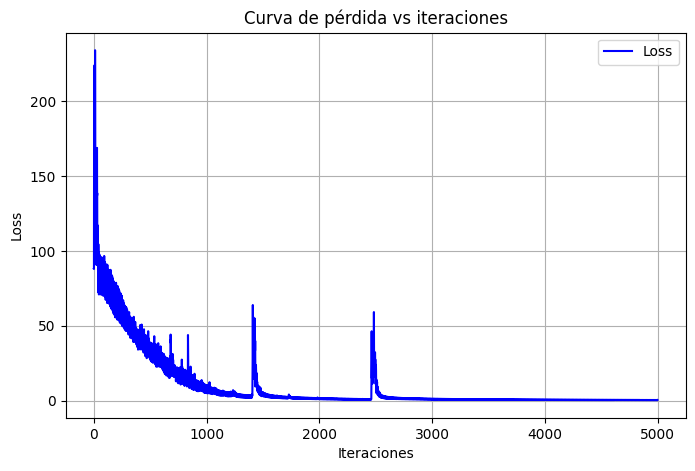

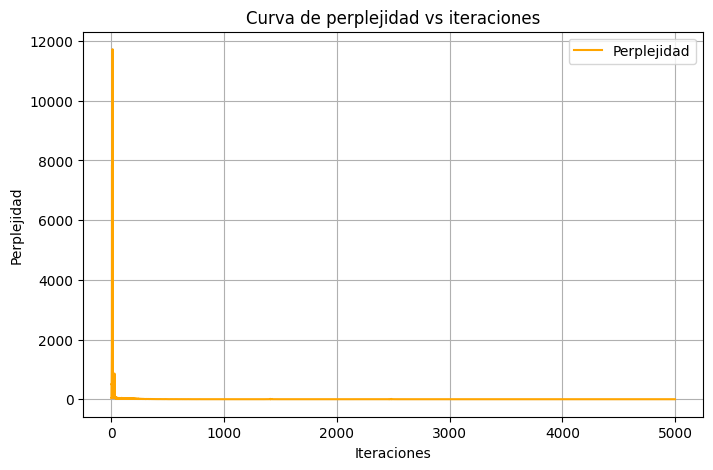

In [ ]:
#Change the path. This was coded in colab
with open('/content/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

rnn = VanillaRNN(n_x=vocab_size, n_h=100, seq_length=25, learning_rate=1e-1)
loss_list, perplexity_list = rnn.train(text, char_to_int, int_to_char, max_iter=5000, clip=True)


rnn.plot_loss(loss_list)
rnn.plot_perplexity(perplexity_list)

This is the content used in input.txt:

kmmatody: nomels bake tho pav.

M:
Atw: and I; thou onsel swere, lo! meroses ssseme noke shy ust but ker, woncter id imire ghy.

What Thes hereth:
Iss:
Drou wort, netesteme here to whont toy,
All My